# This Notebook can be used to inspect and play with the functions for the simulation, Analysis and Plotting

In [ ]:
import numpy as np
import mne
import matplotlib.pyplot as plt
import pandas as pd
import os
from fooof.sim import gen_power_spectrum
from Gating_Functions import extract_tapered_psd, extract_mask, extract_optimal_mask, perform_mlr
from fooof import FOOOF
from scipy.optimize import minimize_scalar
from scipy.signal import stft, istft
import scipy.signal as signal
from Gating_Functions import extract_single_trial_peaks, extract_ERP_peak, compute_MNE_tfr, extract_tfr_band_gating, plot_MLR_results

Extracting parameters from /Volumes/KetanData2/Processed files Thesis Pauline/Processed/GFAR_001_baseline.set...


/var/folders/f0/yk_38ks9693585hklt0mrt9h0000gp/T/ipykernel_76452/4121482708.py:25: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.read_epochs_eeglab(Path + ERP_files[index])


Not setting metadata
43 matching events found
No baseline correction applied
0 projection items activated
Ready.
Emperical SNR: 9.979541745763498
Need more than one channel to make topography for eeg. Disabling interactivity.


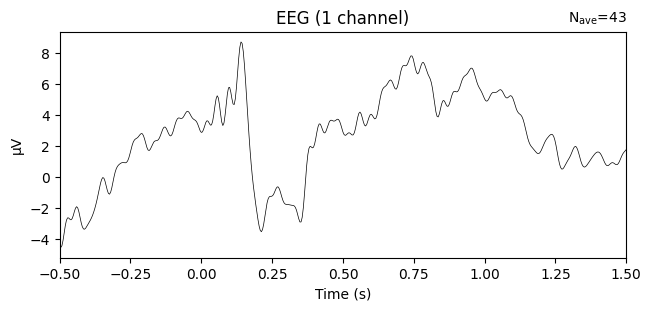

In [17]:
# Load the subjects raw EEG file and calculate the SNR
from Path_Config import Processed_folder as Path
index = 0

Config_get_snr = {'time_beg': 0, 'time_end': .8}
def get_snr(data, times, Config_get_snr = Config_get_snr):
    time_beg = Config_get_snr['time_beg']
    time_end = Config_get_snr['time_end']
    signal_power = np.var(data[(times > time_beg) & (times < time_end)])
    noise_power = np.var(data[(times < 0)])  # Variance across trials & time
    snr_db = 10 * np.log10(signal_power / noise_power) # Compute SNR for each channel
    return snr_db


Get_Foof_config = {'tmin': -.5, 'tmax': 1.5, 'chan_gfar': 128, 'chan_gfas': 104}
def Get_Fooof_Parameters(index, Path, config = Get_Foof_config):
    tmin = config['tmin']
    tmax = config['tmax']
    ERP_files = [f for f in os.listdir(Path) if f.endswith('.set') and not f.startswith('.')]
    name = ERP_files[index]
    if 'GFAS' in name:
         channel2xtract = config['chan_gfas']
    elif 'GFAR' in name:
         channel2xtract = config['chan_gfar']
    epochs = mne.read_epochs_eeglab(Path + ERP_files[index])
    epochs = epochs.crop(tmin = tmin, tmax = tmax)
    evoked = epochs.average().get_data(picks = channel2xtract).squeeze()
    emperical_snr = get_snr(evoked, epochs.times)

    # Fit the foof parameters to the background noise
    aperiodic_params = []
    periodic_params = []
    spectra, freqs = extract_tapered_psd(epochs, tmin=tmin, tmax=tmax, pad_duration=0)
    fm = FOOOF(peak_width_limits=[1, 15], max_n_peaks=3, aperiodic_mode='fixed')
    freq_range = [1, 30]
    for i in range(spectra.shape[0]):
        fm.fit(freqs, spectra[i,channel2xtract,:], freq_range)
        aperiodic_params.append(fm.aperiodic_params_)
        periodic_params.append(fm.peak_params_)
    return aperiodic_params, periodic_params, emperical_snr, epochs

aperiodic_params, periodic_params, emperical_snr, epochs = Get_Fooof_Parameters(index, Path, config = Get_Foof_config)
print(f"Emperical SNR: {emperical_snr}")

epochs.average().plot(picks = 'E128')
plt.show()


250.0

501
43


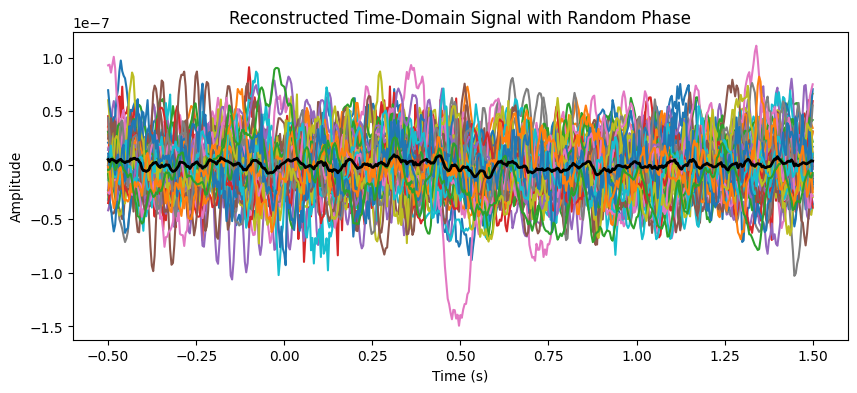

In [3]:
# Define correct number of time points
# Define simulation parameters
sfreq = epochs.info['sfreq']  # Sampling frequency (Hz)
tmin, tmax = -0.5, 1.5  # Time range (pre- and post-stimulus)
n_times = int((tmax - tmin) * sfreq) + 1  # Ensure correct length
times = np.linspace(tmin, tmax, n_times, endpoint=True)  # Generate 500 points
print(len(times))
n_trials = len(aperiodic_params)

Simulate_Background_config = {'noise_level': 0.2, 'freq_range': [1, 125], 'sfreq': sfreq }
def Simulate_Background_Oscillations(n_trials, n_times, aperiodic_params, periodic_params, config = Simulate_Background_config):
    Sim_sig_Background = np.zeros((n_trials, n_times)) 
    sfreq = config['sfreq']
    noise_level = config['noise_level']
    freq_range = config['freq_range']
    print(len(aperiodic_params))

    for ind in range(n_trials):

        freqs, powers, sim_params = gen_power_spectrum(
            [1, sfreq // 2], aperiodic_params[ind], periodic_params[ind].flatten().tolist(), 
            nlv=noise_level, freq_res=sfreq / n_times, return_params=True
        )

        random_phases = np.random.uniform(0, 2 * np.pi, len(powers))
        magnitudes = np.sqrt(powers)
        complex_spectrum = magnitudes * np.exp(1j * random_phases)
        
        full_spectrum = np.concatenate([complex_spectrum, complex_spectrum[-2:0:-1].conj()]) 

        Temp_signal = np.fft.irfft(full_spectrum, n=n_times)  # Ensure length matches n_times
        Sim_sig_Background[ind, :] = Temp_signal
        
    return Sim_sig_Background

Sim_sig_Background = Simulate_Background_Oscillations(n_trials, n_times, aperiodic_params, periodic_params, config = Simulate_Background_config)

# Plot the mean signal across trials
plt.figure(figsize=(10, 4))
plt.plot(times, Sim_sig_Background.T)
plt.plot(times,np.mean(Sim_sig_Background, axis=0), 'k', linewidth=2)
plt.title("Reconstructed Time-Domain Signal with Random Phase")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

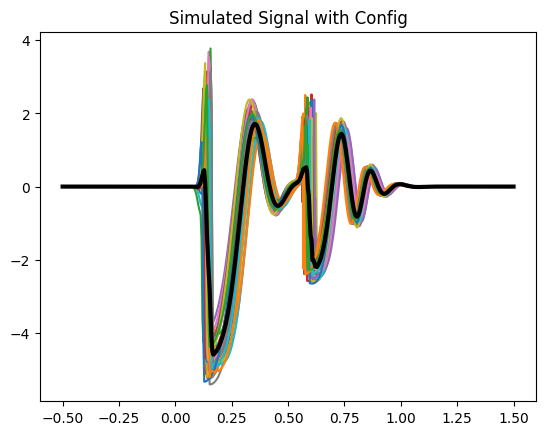

In [4]:
signal_sine_wave_config = {
    "Response_Amplitude_scaling1": 5,
    "Response_Amplitude_scaling2": 2.5,
    "Ideal_latency_1": 0.15,
    "Ideal_latency_2": 0.6,
    "Latency_jitter1_scaling": 0.01,
    "Latency_jitter2_scaling": 0.01,
    "Response_Frequency": 3,
    "sigma_rise": 0.015,
    "sigma_fall": 0.15,
    "sigma_rise_fgaussian": 0.005,
    "sigma_fall_fgaussian": 0.2,
    "phase_range1": [np.pi * 1.2, np.pi * 1.6],
    "phase_range2": [np.pi * 1.0, np.pi * 1.4],
    "jitter_scaling_range": [0.9, 1.1],
}

def Simulate_Signal_Sine_Wave(n_trials, n_times, times, config):
    SimulatedData = np.zeros((n_trials, n_times))

    for i in range(n_trials):
        # Extract parameters
        lat1 = config["Ideal_latency_1"] + config["Latency_jitter1_scaling"] * np.random.randn()
        lat2 = config["Ideal_latency_2"] + config["Latency_jitter2_scaling"] * np.random.randn()
        freq_vec = np.ones(n_times) * config["Response_Frequency"]

        # Frequency Gaussian
        fgauss1 = np.where(
            times < lat1,
            -.9 * np.exp(-((times - lat1)**2) / (2 * config["sigma_rise_fgaussian"]**2)) + 1,
            -.9 * np.exp(-((times - lat1)**2) / (2 * config["sigma_fall_fgaussian"]**2)) + 1
        )
        fgauss2 = np.where(
            times < lat2,
            -.9 * np.exp(-((times - lat2)**2) / (2 * config["sigma_rise_fgaussian"]**2)) + 1,
            -.9 * np.exp(-((times - lat2)**2) / (2 * config["sigma_fall_fgaussian"]**2)) + 1
        )
        freq_vec1 = freq_vec * fgauss1
        freq_vec2 = freq_vec * fgauss2

        # Amplitude Gaussian taper
        asym1 = np.where(
            times < lat1,
            np.exp(-((times - lat1)**2) / (2 * config["sigma_rise"]**2)),
            np.exp(-((times - lat1)**2) / (2 * config["sigma_fall"]**2))
        )
        asym2 = np.where(
            times < lat2,
            np.exp(-((times - lat2)**2) / (2 * config["sigma_rise"]**2)),
            np.exp(-((times - lat2)**2) / (2 * config["sigma_fall"]**2))
        )

        # Sinusoidal responses
        phase1 = np.random.uniform(*config["phase_range1"])
        phase2 = np.random.uniform(*config["phase_range2"])
        R1 = config["Response_Amplitude_scaling1"] * np.sin(2 * np.pi * freq_vec1 * times + phase1) * asym1
        R2 = config["Response_Amplitude_scaling2"] * np.sin(2 * np.pi * freq_vec2 * times + phase2) * asym2

        SimulatedData[i, :] = R1 + R2

    jitter = np.random.uniform(*config["jitter_scaling_range"], size=(SimulatedData.shape[0], 1))
    SimulatedData *= jitter

    return SimulatedData

Simulated_Signal = Simulate_Signal_Sine_Wave(n_trials, n_times, times, config=signal_sine_wave_config)

plt.plot(times, Simulated_Signal.T)
plt.plot(times, Simulated_Signal.mean(axis=0), 'k', linewidth=3)
plt.title("Simulated Signal with Config")
plt.show()

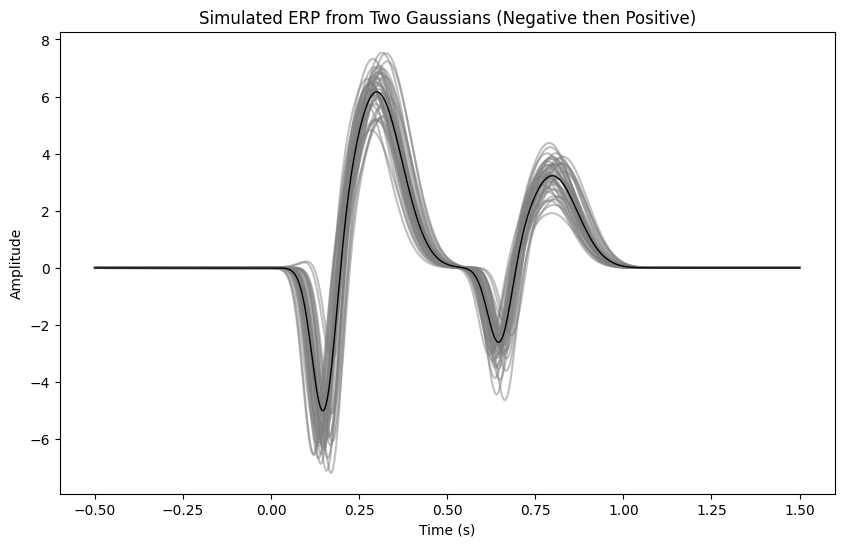

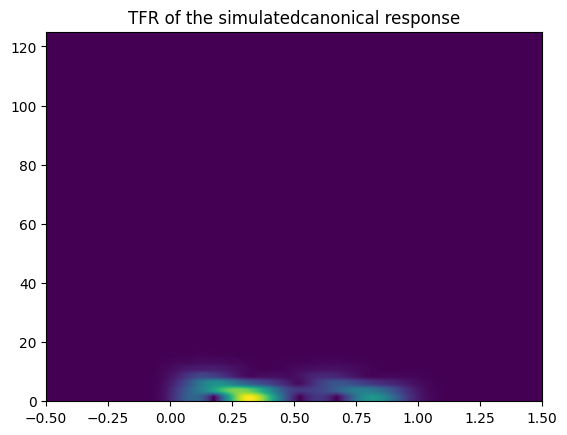

In [5]:
Signal_gaussian_config = {
    "Gating_ratio": 0.5,
    "latency_N1": 0.15,
    "latency_N2": 0.65,
    "sigma1": 0.03,
    "sigma2": 0.07,
    "latency_jitter": 0.015,
    "amplitude_jitter": 0.1,
    "N1_Amplitude": -5
}

def Simulate_Signal_from_Gaussians(n_trials, n_times, times, config):
    # Unpack config
    A1 = -1
    A2 = A1 * config["Gating_ratio"]
    latency_P1 = config["latency_N1"] + 0.15
    latency_P2 = config["latency_N2"] + 0.15

    simulated_trials = np.zeros((n_trials, n_times))
    
    for trial in range(n_trials):
        # Jittered latencies
        trial_latency_N1 = config["latency_N1"] + np.random.randn() * config["latency_jitter"]
        trial_latency_N2 = config["latency_N2"] + np.random.randn() * config["latency_jitter"]
        trial_latency_P1 = latency_P1 + np.random.randn() * config["latency_jitter"]
        trial_latency_P2 = latency_P2 + np.random.randn() * config["latency_jitter"]

        # Jittered amplitudes
        trial_amplitude_N1 = A1 + np.random.randn() * config["amplitude_jitter"]
        trial_amplitude_N2 = A2 + np.random.randn() * config["amplitude_jitter"]
        trial_amplitude_P1 = -A1 + np.random.randn() * config["amplitude_jitter"]
        trial_amplitude_P2 = -A2 + np.random.randn() * config["amplitude_jitter"]

        # ERP components
        erp_negative1 = trial_amplitude_N1 * np.exp(-((times - trial_latency_N1) ** 2) / (2 * config["sigma1"] ** 2))
        erp_positive1 = trial_amplitude_P1 * np.exp(-((times - trial_latency_P1) ** 2) / (2 * config["sigma2"] ** 2))

        erp_negative2 = trial_amplitude_N2 * np.exp(-((times - trial_latency_N2) ** 2) / (2 * config["sigma1"] ** 2))
        erp_positive2 = trial_amplitude_P2 * np.exp(-((times - trial_latency_P2) ** 2) / (2 * config["sigma2"] ** 2))

        # Combine all
        simulated_trials[trial, :] = erp_negative1 + erp_positive1 + erp_negative2 + erp_positive2

    # Scale to desired N1 amplitude
    simulated_erp = simulated_trials.mean(axis=0)
    min_peak = np.min(simulated_erp[(times > 0) & (times < 0.25)])
    scaling_factor = config["N1_Amplitude"] / min_peak
    simulated_trials *= scaling_factor

    return simulated_trials


Simulated_Signal = Simulate_Signal_from_Gaussians(n_trials, n_times, times, config=Signal_gaussian_config)


# Plot individual trials (gray) and the average ERP (black)
plt.figure(figsize=(10, 6))
for trial in range(n_trials):
    plt.plot(times, Simulated_Signal[trial, :], color='gray', alpha=0.5)
plt.plot(times, Simulated_Signal.mean(axis=0), 'k', linewidth=1)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Simulated ERP from Two Gaussians (Negative then Positive)')
plt.show()

# TFR for simulated signal - you dont need this on every iteration. Just for one canonical response will do
f, TFR_time, Simulated_TFR = stft(Simulated_Signal, fs=sfreq, nperseg=100, noverlap=99, boundary='zeros')
TFR_time = np.linspace(-.5, 1.5, Simulated_TFR.shape[2])
baseline_start = int(np.argmin(np.abs(TFR_time - (-.5)))) # Baseline correct
baseline_data_TFR = Simulated_TFR[:,baseline_start:baseline_start + int(sfreq*.4)].mean(axis=1, keepdims=True)
# Simulated_TFR = Simulated_TFR - baseline_data_TFR # subtraction or division?

# plot the TFR using imshow
plt.imshow(np.abs(Simulated_TFR.mean(axis=0)), origin='lower', aspect='auto', extent= [TFR_time[0], TFR_time[-1], f[0], f[-1]] )
plt.title('TFR of the simulatedcanonical response')
plt.show()


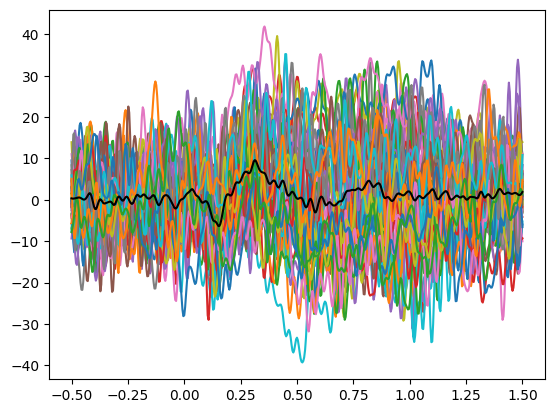

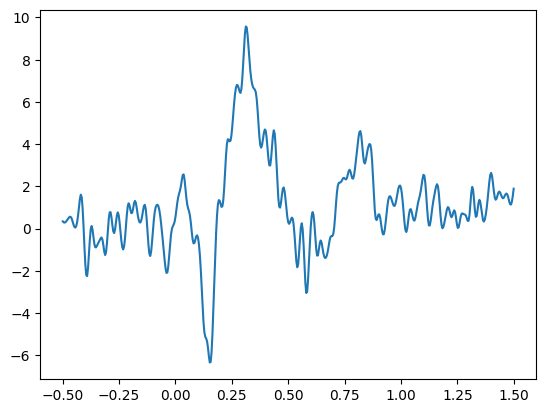

-6.338539775681768
-3.0476102481637075
11.396412114844184


In [6]:
combine_config = {
    "SNR_mode": "Emperical",  # or "Custom" - if custom, the specified snr will be used for the simulation
    "Gaussian_noise_level": .5,
    "desired_snr_db": 6,
    "filter_low": 0.3,
    "filter_high": 35,
    "filter_order": 4,
    "get_snr_config": Config_get_snr
    }


def Combine_and_Scale_Signal(Simulated_Signal, Sim_sig_Background, times, sfreq, emperical_snr, config):

    SNR_mode = config["SNR_mode"]
    Gaussian_noise_level = config["Gaussian_noise_level"]
    desired_snr_db = emperical_snr if SNR_mode == 'Emperical' else config["desired_snr_db"]

    # Normalize background
    Sim_sig_Background = (Sim_sig_Background - np.mean(Sim_sig_Background, axis=1, keepdims=True)) / \
                         np.std(Sim_sig_Background, axis=1, keepdims=True)

    # Func for SNR difference
    def snr_difference(alpha):
        background_ERP = Sim_sig_Background.mean(axis=0)
        Signal_ERP = Simulated_Signal.mean(axis=0)
        Full_ERP = (alpha * background_ERP) + Signal_ERP
        return (get_snr(Full_ERP, times) - desired_snr_db) ** 2

    # Optimize SNR scaling
    result = minimize_scalar(snr_difference, bounds=(0.01, 100), method='bounded')
    alpha_opt = result.x
    Scaled_background = alpha_opt * Sim_sig_Background
    final_signal = Simulated_Signal + Scaled_background

    # Add Gaussian noise
    Gaussian_noise_std = Gaussian_noise_level * np.std(final_signal, axis=1, keepdims=True)
    Gaussian_noise = np.random.normal(0, Gaussian_noise_std, size=final_signal.shape)
    final_signal += Gaussian_noise

    # Bandpass filtering
    nyq_freq = sfreq / 2
    low = config["filter_low"] / nyq_freq
    high = config["filter_high"] / nyq_freq
    b, a = signal.butter(config["filter_order"], [low, high], btype='band')
    final_signal = signal.filtfilt(b, a, final_signal)

    # Baseline correction
    final_signal = final_signal - final_signal[:, (times < 0)].mean(axis=1, keepdims=True)

    # Final SNR
    snr_empirical_db = get_snr(final_signal.mean(axis=0), times, config['get_snr_config'])

    return final_signal, snr_empirical_db



Final_Signal, snr_empirical_db = Combine_and_Scale_Signal(
    Simulated_Signal,
    Sim_sig_Background,
    times,
    sfreq,
    emperical_snr,
    config=combine_config
)

plt.plot(times, Final_Signal.T)
plt.plot(times, Final_Signal.mean(axis=0), 'k', linewidth=1.5)
plt.show()

plt.plot(times,Final_Signal.mean(axis=0))
plt.show()
print(np.min(np.mean(Final_Signal[:,(times > 0) & (times < 0.4)], axis = 0)))
print(np.min(np.mean(Final_Signal[:,(times > .4) & (times < 0.8)], axis = 0)))
print(snr_empirical_db)

Extracting parameters from /Volumes/KetanData2/Processed files Thesis Pauline/Processed/GFAR_001_baseline.set...


/var/folders/f0/yk_38ks9693585hklt0mrt9h0000gp/T/ipykernel_76452/1297147868.py:25: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.read_epochs_eeglab(Path + ERP_files[index])


Not setting metadata
43 matching events found
No baseline correction applied
0 projection items activated
Ready.
Number of aperiodic parameters: 43
Number of periodic parameters: 43
43


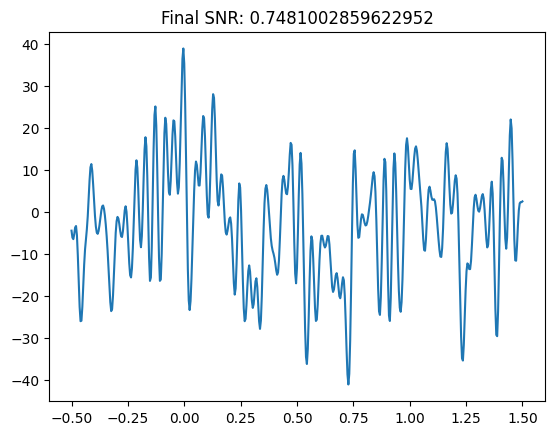

In [ ]:
# Establish Simulation parameters - Check the limits of the parameters you want to use for the simulation
from Path_Config import Processed_folder as Path
Write_Path = Path + 'Simulated_Data/'
aperiodic_params, periodic_params, emperical_snr, epochs = Get_Fooof_Parameters(index, Path, config = Get_Foof_config)
times = epochs.times
sfreq = epochs.info['sfreq']
n_trials = len(aperiodic_params)
n_times = len(times)
print(f'Number of aperiodic parameters: {len(aperiodic_params)}')
print(f'Number of periodic parameters: {len(periodic_params)}')


Simulate_Background_config = {'noise_level': 0.2, 'freq_range': [1, 125], 'sfreq': sfreq }
Sim_sig_Background = Simulate_Background_Oscillations(n_trials, n_times, aperiodic_params, 
                                                      periodic_params, config = Simulate_Background_config)

Signal_gaussian_config['Gating_ratio'] = 0.5
Simulated_Signal = Simulate_Signal_from_Gaussians(n_trials, n_times, times, config=Signal_gaussian_config)

combine_config['Gaussian_noise_level'] = .1
Final_Signal, Final_SNR = Combine_and_Scale_Signal(Simulated_Signal, Sim_sig_Background, times, 
                                                   sfreq, emperical_snr, config=combine_config)


plt.plot(times, Final_Signal.mean(axis=0))
plt.title(f'Final SNR: {Final_SNR}')
plt.show()


In [ ]:
# Higher level functions to run the simulation 
Write_Path = Path + 'Simulated_Data/'
aperiodic_params, periodic_params, emperical_snr, epochs = Get_Fooof_Parameters(0, Path)
times = epochs.times
sfreq = epochs.info['sfreq']

Gating_ratio = 0.3
Gaussian_noise_level = 20

Simulate_data_config = {
    "Gating_ratio": 0.3,
    "Gaussian_noise_level": 1,
    "n_datasets": 50
}

def Simulate_Datasets(Path, times, Simulate_data_config = Simulate_data_config):
    if Simulate_data_config is None:
        from Config import Simulate_data_config
        Simulate_data_config = Simulate_data_config
        
    Gating_ratio = Simulate_data_config["Gating_ratio"]
    Gaussian_noise_level = Simulate_data_config["Gaussian_noise_level"]
    n_datasets = Simulate_data_config["n_datasets"]
    Grand_Average_ERP = np.zeros(len(times))
    All_Simulated_Data = {}
    Extracted = {}
    index = 0
    for ind in range(100):
        print(f'The index is {index}')
        try:
            aperiodic_params, periodic_params, emperical_snr, epochs = Get_Fooof_Parameters(index, Path, config = Get_Foof_config)
        except:
            continue
        epochs = epochs.crop(tmin = -.5, tmax = 1.5)
        info = epochs.info
        sfreq = epochs.info['sfreq']  
        tmin, tmax = -0.5, 1.5
        times = epochs.times
        n_times = len(times)
        n_trials = len(aperiodic_params)
        if index not in Extracted:
            Extracted[index] = {} 

        Sim_sig_Background = Simulate_Background_Oscillations(n_trials, n_times, aperiodic_params, 
                                                      periodic_params, config = Simulate_Background_config)

        Signal_gaussian_config['Gating_ratio'] = Gating_ratio
        Simulated_Signal = Simulate_Signal_from_Gaussians(n_trials, n_times, times, config=Signal_gaussian_config)

        time_beg_n1 = 0
        time_end_n1 = 0.4
        time_beg_n2 = 0.5
        time_end_n2 = 0.9
        epsilon = 1e-10
        # Store the amplitudes of each trial
        N1_amplitudes, N1_latencies = extract_single_trial_peaks(Simulated_Signal, times, stim_onset = 0, sfreq = sfreq)
        Extracted[index]['Pure_N1_amplitudes'] = N1_amplitudes
        Extracted[index]['Pure_N1_latencies'] = N1_latencies

        N2_amplitudes, N2_latencies = extract_single_trial_peaks(Simulated_Signal, times, stim_onset = .5, sfreq = sfreq)
        Extracted[index]['Pure_N2_amplitudes'] = N2_amplitudes
        Extracted[index]['Pure_N2_latencies'] = N2_latencies
        Extracted[index]['Pure_Simulated_gating'] = Extracted[index]['Pure_N2_amplitudes'] / Extracted[index]['Pure_N1_amplitudes']
        
        # Compute ERP (average across trials)
        erp = Simulated_Signal.mean(axis=0)
        N1_erp_amp, N1_erp_latency = extract_ERP_peak(erp, times, stim_onset=0, sfreq=sfreq)
        Extracted[index]['Pure_N1_ERP_amplitude'] = N1_erp_amp
        Extracted[index]['Pure_N1_ERP_latency'] = N1_erp_latency

        N2_erp_amp, N2_erp_latency = extract_ERP_peak(erp, times, stim_onset=0.5, sfreq=sfreq)
        Extracted[index]['Pure_N2_ERP_amplitude'] = N2_erp_amp
        Extracted[index]['Pure_N2_ERP_latency'] = N2_erp_latency
        Extracted[index]['Pure_Simulated_ERP_gating'] = N2_erp_amp / (N1_erp_amp + epsilon)

                
        combine_config['Gaussian_noise_level'] = Gaussian_noise_level

        Final_Signal, Final_SNR = Combine_and_Scale_Signal(Simulated_Signal, Sim_sig_Background, times, 
                                                        sfreq, emperical_snr, config=combine_config)
                

        All_Simulated_Data[index] = Final_Signal
        Grand_Average_ERP += Final_Signal.mean(axis=0)

        # Save the final SNR
        Extracted[index]['Emperical_SNR'] = Final_SNR

        impure_erp = Final_Signal.mean(axis=0)
        imp_N1_amp, imp_N1_latency = extract_ERP_peak(impure_erp, times, stim_onset=0, sfreq=sfreq)
        Extracted[index]['Impure_N1_ERP_amplitude'] = imp_N1_amp
        Extracted[index]['Impure_N1_ERP_latency'] = imp_N1_latency
        imp_N2_amp, imp_N2_latency = extract_ERP_peak(impure_erp, times, stim_onset=0.5, sfreq=sfreq)
        Extracted[index]['Impure_N2_ERP_amplitude'] = imp_N2_amp
        Extracted[index]['Impure_N2_ERP_latency'] = imp_N2_latency
        Extracted[index]['Impure_ERP_gating'] = imp_N2_amp / (imp_N1_amp + epsilon)
                
        # Extract single-trial N1 peaks
        Impure_N1_amplitudes, Impure_N1_latencies = extract_single_trial_peaks(Final_Signal, times, stim_onset=0, sfreq=sfreq)
        Extracted[index]['Impure_N1_single_trial_amplitudes'] = Impure_N1_amplitudes
        Extracted[index]['Impure_N1_single_trial_latencies'] = Impure_N1_latencies
        # Extract single-trial N2 peaks
        Impure_N2_amplitudes, Impure_N2_latencies = extract_single_trial_peaks(Final_Signal, times, stim_onset=0.5, sfreq=sfreq)
        Extracted[index]['Impure_N2_single_trial_amplitudes'] = Impure_N2_amplitudes
        Extracted[index]['Impure_N2_single_trial_latencies'] = Impure_N2_latencies
        Extracted[index]['Impure_single_trial_gating'] = Impure_N2_amplitudes / (Impure_N1_amplitudes + epsilon)

        Simulated_TFR_MNE = compute_MNE_tfr(Final_Signal, sfreq = sfreq, tmin = -.5, freqs=np.linspace(0.1, 35, 35), baseline=(None, -0.2), ch_name='EEG 001')

        # # Extract the gating based on the MNE TFR using the delta band
        delta_gating = extract_tfr_band_gating(Simulated_TFR_MNE, band_name = 'delta', t1 = [time_beg_n1, time_end_n1], t2 = [time_beg_n2, time_end_n2], picks='EEG 001', epsilon=1e-10)
        Extracted[index].update(delta_gating)

        # # Extract the gating based on the MNE TFR using the theta band
        theta_gating = extract_tfr_band_gating(Simulated_TFR_MNE, band_name = 'theta', t1 = [time_beg_n1, time_end_n1], t2 = [time_beg_n2, time_end_n2], picks='EEG 001', epsilon=1e-10)
        Extracted[index].update(theta_gating)

        index += 1
        if index == n_datasets:
            break

    Grand_Average_ERP /= index
    return All_Simulated_Data, Extracted, Grand_Average_ERP

All_Simulated_Data, Extracted_metrics, Grand_Average_ERP = Simulate_Datasets(Path, times = times, Simulate_data_config = Simulate_data_config)


#################### Wavelet Filtering and MLR ####################
mask, Final_Threshold, Relative_S1, Relative_S2, powspect = extract_optimal_mask(Grand_Average_ERP, times, sfreq, 
                                                                       winsize = .25, S1_onset=0, S2_onset=.5, 
                                                                       extract_mask_func = extract_mask, 
                                                                       threshold_drop=0.98, plot_signal = True)

# Maybe save this figure in the folder for this iteration
Threshold_values = np.linspace(.2, 1.00, 100)
plt.plot(Threshold_values, Relative_S1, label = 'S1')
plt.plot(Threshold_values, Relative_S2, label = 'S2')
plt.axvline(x = Final_Threshold, color = 'r', linestyle = '--', label = 'GFAS S1 threshold')
plt.axvline(x = Final_Threshold, color = 'g', linestyle = '--', label = 'GFAS S2 threshold')
plt.title(f'Final Threshold: {Final_Threshold}')
plt.legend()
plt.show()


def Apply_WF_and_MLR(All_Simulated_Data, times, sfreq, mask, plot_sample = False, Intercept = True):
    from Config import perform_mlr_config
    perform_mlr_config['with_intercept'] = Intercept
    Extracted_WF_MLR = {}

    # Loop over the simulated datasets using the keys
    for key in All_Simulated_Data.keys():
        if key not in Extracted_WF_MLR:
            Extracted_WF_MLR[key] = {}
        Final_Signal = All_Simulated_Data[key]
        f, TFR_time, Simulated_TFR = stft(Final_Signal, fs=sfreq, nperseg=100, noverlap=99, boundary='zeros')
        TFR_time = np.linspace(-.5, 1.5, Simulated_TFR.shape[2])
        Zxx_filtered = Simulated_TFR * mask
        _, Final_signal_filtered = istft(Zxx_filtered, fs=sfreq, nperseg=100, noverlap=99, boundary='zeros')
        assert Final_signal_filtered.shape == Final_Signal.shape, 'The shape of the filtered signal is not the same as the original signal'
        base_start = np.argmin(np.abs(times - (-.5)))
        base_end = np.argmin(np.abs(times - (0)))
        Final_signal_filtered -= np.mean(Final_signal_filtered[base_start:base_end])

        Extracted_WF_MLR[key]['Filtered_Signal'] = Final_signal_filtered

        MLR_results_S1 = perform_mlr(Final_signal_filtered, times, sfreq, Final_signal_filtered, Stimulus = 1, config = None)

        Extracted_WF_MLR[key]['MLR_Results_S1'] = MLR_results_S1

        if plot_sample:
            trial = np.random.randint(0, Final_Signal.shape[0])
            plt.plot(times, Final_Signal.mean(axis=0))
            plt.plot(times[MLR_results_S1['Win_start']:MLR_results_S1['Win_end']], MLR_results_S1['fitted_responses'].mean(axis=0))
            plt.plot(times[int(MLR_results_S1['latencies'].mean())], MLR_results_S1['peaks'].mean(), 'o', label='Fitted Response')
            plt.plot(times[int(MLR_results_S1['original_latency'])], MLR_results_S1['original_peak'], 'o', label='Original Response')
            plt.axvline(x = 0, color = 'r', label = 'Stimulus Onset')
            plt.legend()
            plt.show()

        MLR_results_S2 = perform_mlr(Final_signal_filtered, times, sfreq, Final_signal_filtered, Stimulus = 2, config = None)
        
        Extracted_WF_MLR[key]['MLR_Results_S2'] = MLR_results_S2

        if plot_sample:
            trial = np.random.randint(0, Final_Signal.shape[0])
            plt.plot(times, Final_Signal.mean(axis=0))
            plt.plot(times[MLR_results_S2['Win_start']:MLR_results_S2['Win_end']], MLR_results_S2['fitted_responses'].mean(axis=0))
            plt.plot(times[int(MLR_results_S2['latencies'].mean())], MLR_results_S2['peaks'].mean(), 'o', label='Fitted Response')
            plt.plot(times[int(MLR_results_S2['original_latency'])], MLR_results_S2['original_peak'], 'o', label='Original Response')
            plt.axvline(x = 0, color = 'r', label = 'Stimulus Onset')
            plt.legend()
            plt.show()

        # Calculate the gating based on the MLR results
        time_beg_n1 = 0
        time_end_n1 = 0.4
        time_beg_n2 = 0.5
        time_end_n2 = 0.9
        epsilon = 1e-10
        MLR_results_gating = MLR_results_S2['peaks'] / (MLR_results_S1['peaks'] + epsilon)
        Extracted_WF_MLR[key]['MLR_single_trial_gating'] = MLR_results_gating
        Extracted_WF_MLR[key]['MLR_ERP_gating'] = MLR_results_S2['original_peak'] / (MLR_results_S1['original_peak'] + epsilon)

        Simulated_TFR_MNE = compute_MNE_tfr(Final_signal_filtered, sfreq = 250, tmin = -.5, freqs=np.linspace(0.1, 35, 35), baseline=(None, -0.2), ch_name='EEG 001')

        delta_results = extract_tfr_band_gating(Simulated_TFR_MNE, band_name = 'delta', t1 = [time_beg_n1, time_end_n1], t2 = [time_beg_n2, time_end_n2], picks='EEG 001', epsilon=1e-10)
        Extracted_WF_MLR[key].update(delta_results)

        theta_results = extract_tfr_band_gating(Simulated_TFR_MNE, band_name = 'theta',  t1 = [time_beg_n1, time_end_n1], t2 = [time_beg_n2, time_end_n2], picks='EEG 001', epsilon=1e-10)
        Extracted_WF_MLR[key].update(theta_results)

    return Extracted_WF_MLR

Extracted_WF_MLR = Apply_WF_and_MLR(All_Simulated_Data, times, sfreq, mask, plot_sample = False, Intercept = True)


In [ ]:
plot_MLR_results(3, Extracted_WF_MLR, times, All_Simulated_Data)

In [ ]:
# You have everything you need here to start rrunning the loop for the simulation
from Path_Config import Processed_folder as Path
Write_Path = Path + 'Simulated_Data/'
aperiodic_params, periodic_params, emperical_snr, epochs = Get_Fooof_Parameters(0, Path)
times = epochs.times
sfreq = epochs.info['sfreq']

Gating_ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
Gaussian_noise_levels = np.round(np.linspace(0, 3, 10), 2)

for Gating_ratio in Gating_ratios:
    for Gaussian_noise_level in Gaussian_noise_levels:
        # Create a new folder for the simulated data with this gating ratio and noise level
        folder_name = f'Gating_{Gating_ratio}_Noise_{Gaussian_noise_level}'
        if not os.path.exists(os.path.join(Write_Path, folder_name)):
            os.makedirs(os.path.join(Write_Path, folder_name), exist_ok=True)
        Sub_write_path = os.path.join(Write_Path, folder_name)

        All_Simulated_Data, Extracted_metrics, Grand_Average_ERP = Simulate_Datasets(Path, Gating_ratio = Gating_ratio, 
                                                                                    Gaussian_noise_level = Gaussian_noise_level, 
                                                                                    times = times)


        mask, Final_Threshold, Relative_S1, Relative_S2, powspect = extract_optimal_mask(Grand_Average_ERP, times, sfreq, 
                                                                            winsize = .25, S1_onset=0, S2_onset=.5, 
                                                                            extract_mask_func = extract_mask, 
                                                                            threshold_drop=0.98, plot_signal = True)

        # Maybe save this figure in the folder for this iteration
        Threshold_values = np.linspace(.2, 1.00, 100)
        plt.plot(Threshold_values, Relative_S1, label = 'S1')
        plt.plot(Threshold_values, Relative_S2, label = 'S2')
        plt.axvline(x = Final_Threshold, color = 'r', linestyle = '--', label = 'GFAS S1 threshold')
        plt.axvline(x = Final_Threshold, color = 'g', linestyle = '--', label = 'GFAS S2 threshold')
        plt.title(f'Final Threshold: {Final_Threshold}')
        plt.legend()
        plt.savefig(os.path.join(Sub_write_path, 'relative_amplitudes.jpg'), dpi=300, bbox_inches='tight')
        plt.show()

        Extracted_WF_MLR = Apply_WF_and_MLR(All_Simulated_Data, times, sfreq, mask, plot_sample = False, Intercept = True)


        # save all the variables in the folder
        np.save(os.path.join(Sub_write_path, 'All_Simulated_Data.npy'), All_Simulated_Data)
        np.save(os.path.join(Sub_write_path, 'Extracted_metrics.npy'), Extracted_metrics)
        np.save(os.path.join(Sub_write_path, 'Grand_Average_ERP.npy'), Grand_Average_ERP)
        np.save(os.path.join(Sub_write_path, 'Extracted_WF_MLR.npy'), Extracted_WF_MLR)
        np.save(os.path.join(Sub_write_path, 'times.npy'), times)
        np.save(os.path.join(Sub_write_path, 'sfreq.npy'), sfreq)
        np.save(os.path.join(Sub_write_path, 'mask.npy'), mask)
        np.save(os.path.join(Sub_write_path, 'Final_Threshold.npy'), Final_Threshold)
        np.save(os.path.join(Sub_write_path, 'Relative_S1.npy'), Relative_S1)
        np.save(os.path.join(Sub_write_path, 'Relative_S2.npy'), Relative_S2)
        np.save(os.path.join(Sub_write_path, 'powspect.npy'), powspect)



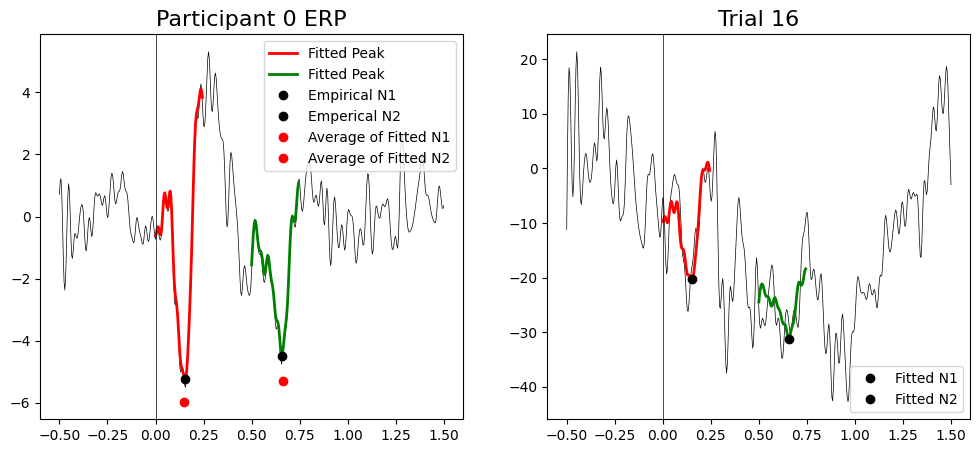

In [12]:
# All_Simulated_Data, Extracted_metrics, Grand_Average_ERP
# Extracted_WF_MLR

p = 0
def plot_MLR_results(p, Extracted_WF_MLR, times, All_Simulated_Data):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    ax = axs[0]
    ax.plot(times, All_Simulated_Data[p].mean(axis=0), 'k', linewidth = .5)
    ax.plot(times[Extracted_WF_MLR[p]['MLR_Results_S1']['Win_start']:Extracted_WF_MLR[p]['MLR_Results_S1']['Win_end']], Extracted_WF_MLR[p]['MLR_Results_S1']['fitted_responses'].mean(axis=0), 'r', linewidth = 2, label = 'Fitted Peak')
    ax.plot(times[Extracted_WF_MLR[p]['MLR_Results_S2']['Win_start']:Extracted_WF_MLR[p]['MLR_Results_S2']['Win_end']], Extracted_WF_MLR[p]['MLR_Results_S2']['fitted_responses'].mean(axis=0), 'g', linewidth = 2, label = 'Fitted Peak')
    ax.plot(times[int(Extracted_WF_MLR[p]['MLR_Results_S1']['original_latency'])], Extracted_WF_MLR[p]['MLR_Results_S1']['original_peak'], 'ko', label='Empirical N1')
    ax.plot(times[int(Extracted_WF_MLR[p]['MLR_Results_S2']['original_latency'])], Extracted_WF_MLR[p]['MLR_Results_S2']['original_peak'], 'ko', label='Emperical N2')
    ax.plot(times[int(Extracted_WF_MLR[p]['MLR_Results_S1']['latencies'].mean())], Extracted_WF_MLR[p]['MLR_Results_S1']['peaks'].mean(), 'ro', label='Average of Fitted N1')
    ax.plot(times[int(Extracted_WF_MLR[p]['MLR_Results_S2']['latencies'].mean())], Extracted_WF_MLR[p]['MLR_Results_S2']['peaks'].mean(), 'ro', label='Average of Fitted N2')
    ax.axvline(x = 0, color = 'k', linewidth = .5)
    ax.set_title(f'Participant {p} ERP', fontsize = 16)
    ax.legend()

    trial = np.random.randint(0, All_Simulated_Data[p].shape[0])
    ax = axs[1]
    ax.plot(times, All_Simulated_Data[p][trial, :], 'k', linewidth = .5)
    ax.plot(times[Extracted_WF_MLR[p]['MLR_Results_S1']['Win_start']:Extracted_WF_MLR[p]['MLR_Results_S1']['Win_end']], Extracted_WF_MLR[p]['MLR_Results_S1']['fitted_responses'][trial, :], 'r', linewidth = 2)
    ax.plot(times[Extracted_WF_MLR[p]['MLR_Results_S2']['Win_start']:Extracted_WF_MLR[p]['MLR_Results_S2']['Win_end']], Extracted_WF_MLR[p]['MLR_Results_S2']['fitted_responses'][trial, :], 'g', linewidth = 2)
    ax.plot(times[int(Extracted_WF_MLR[p]['MLR_Results_S1']['latencies'][trial])], Extracted_WF_MLR[p]['MLR_Results_S1']['peaks'][trial], 'ko', label='Fitted N1')
    ax.plot(times[int(Extracted_WF_MLR[p]['MLR_Results_S2']['latencies'][trial])], Extracted_WF_MLR[p]['MLR_Results_S2']['peaks'][trial], 'ko', label='Fitted N2')
    ax.axvline(x = 0, color = 'k', linewidth = .5)
    ax.set_title(f'Trial {trial}', fontsize = 16)
    ax.legend()

plot_MLR_results(p, Extracted_WF_MLR, times, All_Simulated_Data)



In [54]:
def extract_gating_measures(participant_id, extracted_metrics, extracted_wf_mlr):
    all_keys = list(extracted_metrics.keys())
    all_keys_wf = list(extracted_wf_mlr.keys())

    # Define gating-related keys
    trial_gating_keys = [key for key in all_keys if "gating" in key and "ERP" not in key and "average" not in key]
    erp_gating_keys = [key for key in all_keys if "gating" in key and ("ERP" in key or "average" in key)]

    trial_gating_keys_wf = [key + '_WF' for key in all_keys_wf if "gating" in key and "ERP" not in key and "average" not in key]
    erp_gating_keys_wf = [key + '_WF' for key in all_keys_wf if "gating" in key and ("ERP" in key or "average" in key)]

    # Extract trial-level data
    trial_data = {}
    for key in trial_gating_keys:
        trial_data[key] = extracted_metrics[key]
    for key in trial_gating_keys_wf:
        trial_data[key] = extracted_wf_mlr[key[:-3]]

    for key, val in trial_data.items():
        if isinstance(val, np.ndarray) and val.ndim > 1:
            trial_data[key] = val.flatten()

    trial_df = pd.DataFrame(trial_data)
    trial_df["Dataset"] = participant_id

    # Extract ERP-level data
    erp_data = {}
    for key in erp_gating_keys:
        erp_data[key] = extracted_metrics[key]
    for key in erp_gating_keys_wf:
        erp_data[key] = extracted_wf_mlr[key[:-3]]
    erp_data["Dataset"] = participant_id

    erp_df = pd.DataFrame([erp_data])

    return trial_df, erp_df

dataset = 9
trial_gating_df, erp_gating_df = extract_gating_measures(dataset, Extracted_metrics[dataset], Extracted_WF_MLR[dataset])

In [ ]:
trial_gating_df.head()

In [ ]:
def extract_amplitudes_and_power(participant_id, extracted_metrics, extracted_wf_mlr):
    all_keys = list(extracted_metrics.keys())
    all_keys_wf = list(extracted_wf_mlr.keys())

    # Trial-level and ERP-level amplitude keys
    amplitude_trial_keys = [key for key in all_keys if "amplitude" in key and "ERP" not in key]
    amplitude_erp_keys = [key for key in all_keys if "amplitude" in key and "ERP" in key]

    # Trial-level and ERP-level power keys
    power_trial_keys = [key for key in all_keys if "MNE_TFR_S" in key and "average" not in key]
    power_erp_keys = [key for key in all_keys if "MNE_TFR_S" in key and "average" in key]

    Power_Trial_keys_wf = [key + '_WF' for key in all_keys_wf if "MNE_TFR_S" in key and "average" not in key]
    Power_ERP_keys_wf = [key + '_WF' for key in all_keys_wf if "MNE_TFR_S" in key and "average" in key]

    # Extract trial-level data
    trial_data = {}
    for key in amplitude_trial_keys + power_trial_keys:
        trial_data[key] = extracted_metrics[key]
    for key in ['MLR_Results_S1', 'MLR_Results_S2']:
        trial_data[f'{key}_peaks'] = extracted_wf_mlr[key]['peaks']
    for key in Power_Trial_keys_wf:
        trial_data[key] = extracted_wf_mlr[key[:-3]]
    
    # Flatten anything that's more than 1D
    for key, val in trial_data.items():
        if isinstance(val, np.ndarray) and val.ndim > 1:
            trial_data[key] = val.flatten()

    trial_df = pd.DataFrame(trial_data)
    trial_df["Dataset"] = participant_id

    # Extract ERP-level data
    erp_data = {}
    for key in amplitude_erp_keys + power_erp_keys:
        erp_data[key] = extracted_metrics[key]
    for key in Power_ERP_keys_wf:
        erp_data[key] = extracted_wf_mlr[key[:-3]]
    erp_data['S1_ERP_peak_MLR'] = extracted_wf_mlr['MLR_Results_S1']['original_peak']
    erp_data['S2_ERP_peak_MLR'] = extracted_wf_mlr['MLR_Results_S2']['original_peak']
    erp_data["Dataset"] = participant_id

    erp_df = pd.DataFrame([erp_data])

    return trial_df, erp_df

trial_df, erp_df = extract_amplitudes_and_power(0, Extracted_metrics[0], Extracted_WF_MLR[0])


In [23]:
print(trial_df.shape)
print(erp_df.shape)


(43, 15)
(1, 15)
